In [2]:
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils import data
import torchvision
from torchvision import transforms
def get_dataloader_workers():  #@save
    """使用2个进程来读取数据"""
    return 2
def load_data_fashion_mnist(batch_size, resize = None):  #@save
    """下载 Fashion-mnist 数据集，然后加载到数据内存中"""
    """
    transforms.ToTensor:
    Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor
    """
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root = 'C:/Users/hasee/Desktop/cvtf', 
                                                    train = True, transform = trans, download = True)
    mnist_test = torchvision.datasets.FashionMNIST(root = 'C:/Users/hasee/Desktop/cvtf', 
                                                    train = False, transform = trans, download = True)
    return (data.DataLoader(mnist_train, batch_size, shuffle = True, num_workers = get_dataloader_workers()), 
            data.DataLoader(mnist_test, batch_size, shuffle = False, num_workers = get_dataloader_workers()))

In [3]:
class Accumulator:  #@save
    """在 n 个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的总数"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [5]:
from IPython import display
import matplotlib.pyplot as plt
def use_svg_display():
    # 使用 svg 格式在 jupyter 中绘图
    display.set_matplotlib_formats('svg')
def set_figsize(figsize = (3.5, 2.5)):
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴。"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, 
         xlim=None, ylim=None, xscale='linear', yscale='linear', 
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点。"""
    if legend is None:
        legend = []
    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()
    # 如果 `X` 有⼀个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or 
                isinstance(X, list) and not hasattr(X[0], "__len__"))
    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [6]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel = None, ylabel = None, 
                 legend = None, xlim = None, ylim = None, 
                 xscale = 'linear', yscale = 'linear', 
                 fmts = ('-', 'm--', 'g-.', 'r:'), 
                 nrows = 1, ncols = 1,  figsize = (3.5, 2.5)):
        """增量的绘制多条线"""
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize = figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, 
                                                xscale, yscale, legend)
        self.x, self.y, self.fmts = None, None, fmts
    def add(self, x, y):
        """向表中添加多个数据点"""
        if not hasattr(y, '__len__'):
            y = [y]
        n = len(y)
        if not hasattr(x, '__len__'):
            x = [x] * n
        if not self.x:
            self.x = [[] for _ in range(n)]
        if not self.y:
            self.y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.x[i].append(a)
                self.y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.x, self.y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait = True)

In [7]:
import numpy as np
import time
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累积时间"""
        return np.array(self.times).cumsum().tolist()

In [8]:
def try_gpu(i = 0):  #@save
    """如果存在，则返回 gpu(i)，否则返回 cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device('cpu')

In [9]:
def evaluate_accuracy_gpu(net, data_iter, device = None): #@save
    """使用 GPU 计算模型在数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    for x, y in data_iter:
        if isinstance(x, list):
            # BERT 微调所需的
            x = [X.to(device) for X in x]
        else:
            x = x.to(device)
        y = y.to(device)
        metric.add(accuracy(net(x), y), y.numel())
    return metric[0] / metric[1]

In [10]:
def train_ch6(net, train_iter, test_iter, 
              num_epochs, lr, device):  #@save
    """使用 GPU 训练模型"""
    def init_weight(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    print('training on:', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel = 'epoch', xlim = [1, num_epochs], 
                        legend = ['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (x, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            y_hat = net(x)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * x.shape[0], 
                           accuracy(y_hat, y), x.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, 
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f"loss: {train_l:.3f}, train acc: {train_acc:.3f}, \
          test_acc: {test_acc:.3f}")
    print(f"{metric[2] * num_epochs / timer.sum():.1f} example/sec, on {str(device)}")

In [31]:
# -------------------------------------------------------
# 1.深度卷积神经网络（AlexNet）
import torch
import torch.nn
from d2l import torch as d2l

In [32]:
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size = 11, stride = 4, padding = 1), 
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size = 3, stride = 2), 
    nn.Conv2d(96, 256, kernel_size = 5, padding = 2), nn.ReLU(), 
    nn.MaxPool2d(kernel_size = 3, stride = 2), 
    nn.Conv2d(256, 384, kernel_size = 3, padding = 1), nn.ReLU(), 
    nn.Conv2d(384, 384, kernel_size = 3, padding = 1), nn.ReLU(), 
    nn.Conv2d(384, 256, kernel_size = 3, padding = 1), nn.ReLU(), 
    nn.MaxPool2d(kernel_size = 3, stride = 2), 
    nn.Flatten(), 
    nn.Linear(5 * 5 * 256, 4096), nn.ReLU(), nn.Dropout(p = 0.5), 
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p = 0.5), 
    nn.Linear(4096, 10))

In [33]:
x = torch.randn(1, 1, 224, 224)
for layer in net:
    x = layer(x)
    print(layer.__class__.__name__, '-----output shape: \t', x.shape)

Conv2d -----output shape: 	 torch.Size([1, 96, 54, 54])
ReLU -----output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d -----output shape: 	 torch.Size([1, 96, 26, 26])
Conv2d -----output shape: 	 torch.Size([1, 256, 26, 26])
ReLU -----output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d -----output shape: 	 torch.Size([1, 256, 12, 12])
Conv2d -----output shape: 	 torch.Size([1, 384, 12, 12])
ReLU -----output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d -----output shape: 	 torch.Size([1, 384, 12, 12])
ReLU -----output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d -----output shape: 	 torch.Size([1, 256, 12, 12])
ReLU -----output shape: 	 torch.Size([1, 256, 12, 12])
MaxPool2d -----output shape: 	 torch.Size([1, 256, 5, 5])
Flatten -----output shape: 	 torch.Size([1, 6400])
Linear -----output shape: 	 torch.Size([1, 4096])
ReLU -----output shape: 	 torch.Size([1, 4096])
Dropout -----output shape: 	 torch.Size([1, 4096])
Linear -----output shape: 	 torch.Size([1, 4096])
ReLU -----outpu

In [34]:
# 读取数据集
batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, 
                                                resize = 224)

loss: 0.333, train acc: 0.878,           test_acc: 0.877
572.8 example/sec, on cuda:0


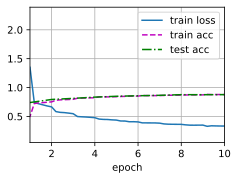

In [35]:
# 训练网络
lr, num_epochs = 0.01, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [36]:
# 2.使用块的网络（VGG）
import torch 
from torch import nn
from d2l import torch as d2l

In [37]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, 
                                kernel_size = 3, padding = 1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
    return nn.Sequential(*layers)

In [38]:
# VGG 网络
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [39]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    return nn.Sequential(*conv_blks, 
                         nn.Flatten(), 
                         nn.Linear(out_channels * 7 * 7, 4096), 
                         nn.ReLU(), nn.Dropout(0.5), 
                         nn.Linear(4096, 4096), 
                         nn.ReLU(), nn.Dropout(0.5), 
                         nn.Linear(4096, 10))

In [40]:
net = vgg(conv_arch)

In [41]:
x = torch.randn(size = (1, 1, 224, 224))
for blk in net:
    x = blk(x)
    print(blk.__class__.__name__, 'output shape:\t', x.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [42]:
# 训练模型
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

In [49]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, 
                                                resize = 224)

training on: cuda:0


C:\Users\hasee\AppData\Local\Temp/ipykernel_9196/4262910671.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 4.00 GiB total capacity; 2.61 GiB already allocated; 48.29 MiB free; 2.66 GiB reserved in total by PyTorch)

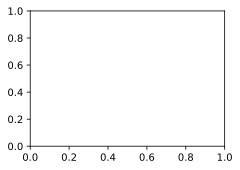

In [43]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [44]:
# -----------------------------
# 3.网络中的网络（NiN）
import torch 
from torch import nn
from d2l import torch as d2l

In [45]:
def nin_block(in_channels, out_channels, 
              kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 
                  kernel_size, strides, padding), 
        nn.ReLU(), 
        nn.Conv2d(out_channels, out_channels, kernel_size = 1), 
        nn.ReLU(), 
        nn.Conv2d(out_channels, out_channels, 
                             kernel_size = 1), 
        nn.ReLU())

In [46]:
# NiN 模型
net = nn.Sequential(
    nin_block(1, 96, kernel_size = 11, strides = 4, padding = 0), 
    nn.MaxPool2d(3, stride = 2), 
    nin_block(96, 256, kernel_size = 5, strides = 1, padding = 2), 
    nn.MaxPool2d(3, stride = 2), 
    nin_block(256, 384, kernel_size = 3, strides = 1, padding = 1), 
    nn.MaxPool2d(3, stride = 2), nn.Dropout(0.5), 
    nin_block(384, 10, kernel_size = 3, strides = 1, padding = 1), 
    nn.AdaptiveAvgPool2d((1, 1)),   # 全局平均池化
    nn.Flatten())  # 将四维的输出转换成二维的输出，其形状为（批量大小，10）

In [47]:
x = torch.randn(size = (1, 1, 224, 224))
for layer in net:
    x = layer(x)
    print(layer.__class__.__name__, '--output shape: \t', x.shape)

Sequential --output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d --output shape: 	 torch.Size([1, 96, 26, 26])
Sequential --output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d --output shape: 	 torch.Size([1, 256, 12, 12])
Sequential --output shape: 	 torch.Size([1, 384, 12, 12])
MaxPool2d --output shape: 	 torch.Size([1, 384, 5, 5])
Dropout --output shape: 	 torch.Size([1, 384, 5, 5])
Sequential --output shape: 	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d --output shape: 	 torch.Size([1, 10, 1, 1])
Flatten --output shape: 	 torch.Size([1, 10])


In [48]:
lr, num_epochs, batch_size = 0.1, 10, 128

In [49]:
train_iter, tets_iter = load_data_fashion_mnist(batch_size, 
                                                resize = 224)

training on: cuda:0


C:\Users\hasee\AppData\Local\Temp/ipykernel_9196/4262910671.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


RuntimeError: CUDA out of memory. Tried to allocate 138.00 MiB (GPU 0; 4.00 GiB total capacity; 2.63 GiB already allocated; 36.29 MiB free; 2.67 GiB reserved in total by PyTorch)

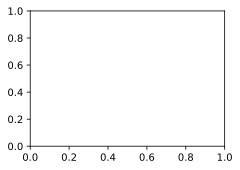

In [50]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [70]:
# -----------------------
# 4.含并行连接的网络（GoogLeNet）
import torch 
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

In [77]:
# Inception 块
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size = 1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size = 1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], 
                              kernel_size = 3, padding = 1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size = 1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], 
                              kernel_size = 5, padding = 2)
        self.p4_1 = nn.MaxPool2d(kernel_size = 3, 
                                 stride = 1, padding = 1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size = 1)
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim = 1)

In [78]:
# GoogLeNet 模型
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3), 
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

In [79]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size = 1), 
    nn.ReLU(), 
    nn.Conv2d(64, 192, kernel_size = 3, padding = 1), 
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

In [80]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32), 
    Inception(256, 128, (128, 192), (32, 96), 64), 
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

In [82]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64), 
    Inception(512, 160, (112, 224), (24, 64), 64), 
    Inception(512, 128, (128, 256), (24, 64), 64), 
    Inception(512, 112, (144, 288), (32, 64), 64), 
    Inception(528, 256, (160, 320), (32, 128), 128), 
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

In [83]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128), 
    Inception(832, 384, (192, 384), (48, 128), 128), 
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

In [84]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [92]:
x = torch.randn(size = (1, 1, 96, 96))
for layer in net:
    x = layer(x)
    print(layer.__class__.__name__, 'output shape:    \t', x.shape)

Sequential output shape:    	 torch.Size([1, 64, 24, 24])
Sequential output shape:    	 torch.Size([1, 192, 12, 12])
Sequential output shape:    	 torch.Size([1, 480, 6, 6])
Sequential output shape:    	 torch.Size([1, 832, 3, 3])
Sequential output shape:    	 torch.Size([1, 1024])
Linear output shape:    	 torch.Size([1, 10])


In [94]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
trian_iter, test_iter = load_data_fashion_mnist(batch_size, 
                                                resize = 96)

In [ ]:
# train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [95]:
# 5.批量归一化
import torch
from torch import nn
from d2l import torch as d2l

In [97]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过 `is_grad_enabled` 来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使⽤传⼊的移动平均所得的均值和⽅差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2: 
            # 使⽤全连接层的情况，计算特征维上的均值和⽅差
            mean = X.mean(dim = 0)
            var = ((X - mean) ** 2).mean(dim = 0)
        else:
            # 使⽤⼆维卷积层的情况，计算通道维上（axis = 1）的均值和⽅差。
            # 这⾥我们需要保持X的形状以便后⾯可以做⼴播运算
            mean = X.mean(dim=(0, 2, 3), keepdim = True)
            var = ((X - mean) ** 2).mean(dim = (0, 2, 3), 
                                         keepdim = True) 
        # 训练模式下，⽤当前的均值和⽅差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和⽅差
        moving_mean = momentum * moving_mean + (
            1.0 - momentum) * mean
        moving_var = momentum * moving_var + (
            1.0 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [98]:
class BatchNorm(nn.Module):
    # num_features: 完全连接层的输出数量或则卷积层的输出通道数
    # num_dims: 2 表示完全连接层， 4 表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    def forward(self, x):
        if self.moving_mean.device != x.device:
            self.moving_mean = self.moving_mean.to(x.device)
            self.moving_var = self.moving_var.to(x.device)
        y, self.moving_mean, self.moving_var = batch_norm(
            x, self.gamma, self.beta, self.moving_mean, 
            self.moving_var, eps = 1e-5, momentum = 0.9)
        return y

In [99]:
# 使用归一化层的 LeNet
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size = 5), 
    BatchNorm(6, num_dims = 4), 
    nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size = 2, stride = 2), 
    nn.Conv2d(6, 16, kernel_size = 5), 
    BatchNorm(16, num_dims = 4), 
    nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size = 2, stride = 2), 
    nn.Flatten(), 
    nn.Linear(16 * 4 * 4, 120), 
    BatchNorm(120, num_dims = 2), 
    nn.Sigmoid(), 
    nn.Linear(120, 84), 
    BatchNorm(84, num_dims = 2), 
    nn.Sigmoid(), 
    nn.Linear(84, 10))

In [100]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [ ]:
# train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [ ]:
# net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

In [103]:
# 简明实现
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size = 5), 
    nn.BatchNorm2d(6), 
    nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size = 2, stride = 2), 
    nn.Conv2d(6, 16, kernel_size = 5), 
    nn.BatchNorm2d(16), 
    nn.Sigmoid(), 
    nn.MaxPool2d(kernel_size = 2, stride = 2), 
    nn.Flatten(), 
    nn.Linear(16 * 4 * 4, 120), 
    nn.BatchNorm2d(120), 
    nn.Sigmoid(), 
    nn.Linear(120, 84), 
    nn.BatchNorm2d(84), 
    nn.Sigmoid(), 
    nn.Linear(84, 10))

In [104]:
# train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [112]:
# 6.残差网络（ResNet）
import torch 
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

In [113]:
# 残差快
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, 
                 use_1x1_conv = False, strides = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            input_channels, num_channels, 
            kernel_size = 3, padding = 1, stride = strides)
        self.conv2 = nn.Conv2d(
            num_channels, num_channels, 
            kernel_size = 3, padding = 1)
        if use_1x1_conv:
            self.conv3 = nn.Conv2d(
                input_channels, num_channels, 
                kernel_size = 1, stride = strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace = True)
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.conv3:
            x = self.conv3(x)
        y += x
        return F.relu(y)

In [114]:
blk = Residual(3, 3)
x = torch.rand(4, 3, 6, 6)
y = blk(x)
y.shape

torch.Size([4, 3, 6, 6])

In [115]:
blk = Residual(3, 6, use_1x1_conv = True, strides = 2)
y = blk(x)
y.shape

torch.Size([4, 6, 3, 3])

In [120]:
# ResNet 模型
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3), 
    nn.BatchNorm2d(64), 
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

In [121]:
def resnet_block(input_channels, num_channels, 
                 num_residuals, first_block = False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, 
                         use_1x1_conv = True, strides = 2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [122]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block = True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [124]:
net = nn.Sequential(
    b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)), 
    nn.Flatten(), 
    nn.Linear(512, 10))

In [136]:
x = torch.rand(size=(1, 1, 224, 224))

In [137]:
for layer in net:
    x = layer(x)
    print(layer.__class__.__name__, 'output shape:  \t', x.shape)

Sequential output shape:  	 torch.Size([1, 64, 56, 56])
Sequential output shape:  	 torch.Size([1, 64, 56, 56])
Sequential output shape:  	 torch.Size([1, 128, 28, 28])
Sequential output shape:  	 torch.Size([1, 256, 14, 14])
Sequential output shape:  	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:  	 torch.Size([1, 512, 1, 1])
Flatten output shape:  	 torch.Size([1, 512])
Linear output shape:  	 torch.Size([1, 10])


In [138]:
# 训练模型
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_fashion_mnist(
    batch_size, resize = 96)

In [139]:
# train_ch6(net, train_iter, test_iter, num_eposhs, lr, try_gpu())

In [1]:
# 7.稠密连接网络
# 稠密块体
a = [4, 4, 4, 4]
for i, b in enumerate(a):
    print(i, b)

0 4
1 4
2 4
3 4


In [13]:
import torch
from torch import nn
from d2l import torch as d2l

In [14]:
# 稠密块体
def conv_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels), 
                         nn.ReLU(), 
                         nn.Conv2d(
                             input_channels, num_channels,
                             kernel_size = 3, padding = 1))

In [15]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, 
                 input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    def forward(self, x):
        for blk in self.net:
            y = blk(x)
            x = torch.cat((x, y), dim = 1)
        return x

In [16]:
blk = DenseBlock(2, 3, 10)
x = torch.randn(4, 3, 8, 8)
y = blk(x)
y.shape

torch.Size([4, 23, 8, 8])

In [17]:
# 过渡层
def transition_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels), 
                         nn.ReLU(), 
                         nn.Conv2d(
                             input_channels, num_channels, 
                             kernel_size = 1), 
                         nn.AvgPool2d(kernel_size = 2, 
                                      stride = 2))

In [18]:
blk = transition_block(23, 10)
blk(y).shape

torch.Size([4, 10, 4, 4])

In [19]:
# DenseNet 模型
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
    nn.BatchNorm2d(64), 
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))

In [20]:
# NUM-channels 为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [21]:
net = nn.Sequential(
    b1, *blks, nn.BatchNorm2d(num_channels), nn.ReLU(), 
    nn.AdaptiveMaxPool2d((1, 1)), 
    nn.Flatten(), 
    nn.Linear(num_channels, 10))

In [23]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = load_data_fashion_mnist(
    batch_size, resize = 96)

training on: cuda:0


C:\Users\hasee\AppData\Local\Temp/ipykernel_9196/4262910671.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


RuntimeError: CUDA out of memory. Tried to allocate 138.00 MiB (GPU 0; 4.00 GiB total capacity; 2.65 GiB already allocated; 10.29 MiB free; 2.70 GiB reserved in total by PyTorch)

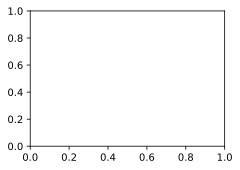

In [51]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())